In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)


,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  393318
Total transactions in test dataset:  97195


In [4]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [5]:
df_train_mcc = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

df_train_trx_category = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

df_train = pd.merge(
    df_train_mcc,
    df_train_trx_category,
    left_index=True,
    right_index=True,
)


In [6]:
df_train.head()

,MCC_mean_742,MCC_mean_763,MCC_mean_780,MCC_mean_1520,MCC_mean_1711,MCC_mean_1731,MCC_mean_1750,MCC_mean_1799,MCC_mean_2741,MCC_mean_2842,...,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
cl_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,182000.0,245747.14,0.0,0.0,0.0


In [7]:
df_targets = raw_df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)
df_targets.head()


df_train = pd.merge(
    df_train,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [8]:
df_test_mcc = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

df_test_trx_category = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

df_test = pd.merge(
    df_test_mcc,
    df_test_trx_category,
    left_index=True,
    right_index=True,
)

In [9]:
df_test = pd.merge(
    df_test,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [10]:
X_test = df_test.drop(['target_flag'], axis=1)
y_test = df_test['target_flag']

X_train = df_train.drop(['target_flag'], axis=1)
y_train = df_train['target_flag']

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [12]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [16]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0).fit(X_train[cols], y_train)

In [17]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [18]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.81


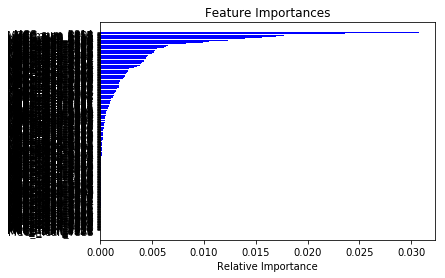

In [34]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [52]:
for i in indices:
    if features[i] in df_test:
        X_test = df_test.drop(features[i], axis=1)
    if features[i] in df_train:
        X_train = df_train.drop(features[i], axis=1)

y_test = df_test['target_flag']
y_train = df_train['target_flag']

In [53]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [54]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0).fit(X_train[cols], y_train)

In [55]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [56]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  1.0
